# Voltage clamp analysis scripts for Slm2 KO and Nrxn1, Nrxn2 and Nrxn3 AS4 exon rescues 

This notebook consists of a script to obtain an input-output curve, where inputs are current stimuli to presynaptic neurons (such as Schaffer Collaterals) and outputs are excitatory post synaptic currents (EPSCs) from cells recorded in whole-cell patch clamp with voltage clamp configuration. 

1. Section with functions used to extract measures of input resistance, membrane resistance, and EPSC peak amplitude.
2. Section with master functions that are run to obtain DataFrames for plotting the outputs of each cell unto their respective folders in the dataset, and for compiling all measurements to plot input-output curve and run statistics

The format of the data that this script follows:
- Directory of individual mice that were sliced
    - Directory of individual cells that were recorded
    - if the script has run already on the dataset, folders with `_processed` suffix appear with plots for each cell
        - Collection of abf files where each file corresponds to a single stimulus intensity
        - an excel sheet denoting the value of said intensity with the abf file, along with some info for that cell
        

## 1. Under-the-hood functions

### I - Instalation of libraries and listing directories of data

In [1]:
pip install --upgrade pyabf

Requirement already up-to-date: pyabf in /Users/adrianalejandro/opt/anaconda3/lib/python3.7/site-packages (2.3.5)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyabf
import pyabf.tools.memtest 
import matplotlib.pyplot as plt
import numpy as np
import os 
import os.path

import csv
import pandas as pnd
from tkinter import Tk
from tkinter import filedialog
from tkinter import Tk
from tkinter.filedialog import askdirectory
import warnings

import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

/Users/adrianalejandro/opt/anaconda3/lib/python3.7/site-packages/pyabf/tools/memtest.py:22: UserWarning: The pyabf package is designed for reading ABF files (not analyzing them). This module is experimental, provided only for backwards compatibility, and its API may change in future releases. Users are encouraged to write their own ABF analysis code.
  "This module is experimental, provided only for backwards compatibility, and its API may change in future releases. " +


### II - File handling stuff

In [3]:
def get_mV_step_interval(abf):
    """Parses through raw text to obtain mV step interval in membrane test. This is usually programmed to occur near 
    the end of each sweep. Assumes that there is only a single voltage step in voltage-clamp configuration 
    experiments.
    
    arguments:
    abf = string with abf file name
    """
    abf.setSweep(0,channel=0)
    raw_str = str(abf.sweepEpochs)
    parsed_str = raw_str.split(', ') #separate by commas
    parsed_total = (len(parsed_str)) 
    for i in range(parsed_total):
        if '0.00' not in parsed_str[i]: #if there's a non-zero value of the command waveform at this epoch
            values = parsed_str[i][parsed_str[i].find("[")+1:parsed_str[i].find("]")] #extracts string inside []
    step_points = (values.split(':'))
    step_start, step_end = int(step_points[0]), int(step_points[1])
    return step_start, step_end

In [4]:
def get_xlxs_data(mouse,contents): 
    """Obtains values specified from experimental notes onto excel: gets number of cells per experiment, intensities 
    of stimuli, and list of ABF files.
    
    arguments:
    mouse = str, name of mouse 
    contents = output from os.listdir('.'), directory of folder with data from one cell
    """
    for file in contents:
        if mouse in file: #experimental notes file is the only one in each mouse folder with the name of that mouse
            exp_notes = pnd.read_excel(file)
            stim_int = exp_notes['Stim Intensity (uA)'].tolist()
            cellnum = exp_notes['cellnum']
            cellnum = int(cellnum[0])
            valid_ABFs = exp_notes['File'].tolist()
            if 'Baseline' in str(stim_int[0]): #check if there's a test run before the stimulus set
                stim_int.pop(0) #First stimulus is part of a test run (I THINK, NEED TO FIGURE THIS OUT)
                valid_ABFs.pop(0) #the first abf file in this protocol is always a test run, not part of the stimulus set
            for x in range(len(valid_ABFs)):
                valid_ABFs[x] = valid_ABFs[x].strip('\t\n') #so that the list of files to open and read are truly abf
    return stim_int, cellnum, valid_ABFs

### III - Measurements, Resistances, peak currents

In [5]:
def get_resistances_v2(ch_ind,step_start, step_end, abf):
    """Obtains input resistance and series resistance of all sweeps from single ABF file.Baseline voltage is set 
    to be 10 frames before onset of voltage step.
    
    arguments:
    ch_ind = int, channel index, used to specify voltage and current channels
    step_start, step_end = int, interval of interest in trace 
    abf = str, filename of abf
    """
    Rs = []
    Ri = []
    for i in abf.sweepList:
        abf.setSweep(i, channel = ch_ind) # channel = cell number
        neg_maxI = min(abf.sweepY[step_start:step_end]) # max current
        Input_I = abf.sweepY[step_end - 10]
        neg_max_index = int(np.argmin(abf.sweepY[step_start:step_end]) + step_start)
        abf.setSweep(i,channel= ch_ind + 1) #check if this indexes right on plot
        SeriesR = ((abf.sweepY[neg_max_index]-abf.sweepY[step_start - 10])/neg_maxI) * 1000 #convert from gigaohms to megaohms
        Rs.append(SeriesR)
        InputR = ((abf.sweepY[step_end -10]--abf.sweepY[step_start - 10])/Input_I) * 1000 
        Ri.append(InputR) 
        
        # Note, have average voltage for the baseline instead, more precise
    return Ri, Rs 

In [6]:
def get_RiRs_persweep_v2(ch_ind,abf):
    """Employs get_resistances_v2 function and gets time interval of voltage step, returns resistances as lists.    
    
    arguments:
    ch_ind = int, channel index, used to specify voltage and current channels
    valid_csv = str, validated csv metadata file
    abf = class variable, obtained with pyabf.ABF(_)
    """
    step_start, step_end = get_mV_step_interval(abf)
    Ri, Rs = get_resistances_v2(ch_ind,step_start, step_end,abf)
    return Ri, Rs

In [7]:
def plot_Rtest_v2(sweep_ind,abf,i1,i2):
    """Accesory for visualizing resistances from new function above. 
    arguments:
    sweep_ind = int, index of sweep to visualize
    abf = class variable, obtained with pyabf.ABF(_)
    i1, i2 = indices of chunk of trace to plot
    """
    abf.setSweep(sweep_ind, channel = 0)
    frame_axis = range(abf.sweepPointCount)
    fig = plt.figure(figsize=(8, 4))
    
    ax1 = fig.add_subplot(211)
    ax1.set_title("Resistance test")
    ax1.plot(frame_axis[i1:i2], abf.sweepY[i1:i2])
    ax1.set_ylabel(abf.sweepLabelY)
    
    abf.setSweep(sweep_ind, channel = 1)
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.plot(frame_axis[i1:i2], abf.sweepY[i1:i2], color='r')
    ax2.set_xlabel('data_frames')
    ax2.set_ylabel(abf.sweepLabelY)

    return fig

In [8]:
def get_mean_trace(abf,ch_ind):
    """Gets mean trace of specified cell from current traces in ABF file. Assumes ch_ind is either 0 or 2
    
    arguments: 
    abf = class variable, obtained with pyabf.ABF(_)
    ch_ind = int, channel index, used to specify voltage and current channels
    """
    all_traces = []
    for i in abf.sweepList:
        abf.setSweep(i, channel=ch_ind)
        all_traces.append(abf.sweepY)
    mean_trace = np.mean(all_traces,axis=0)
    return mean_trace

In [9]:
### No longer used but keeping in future versions in case needed
#Outputs of this function are saved in each cell folder
def plot_mean_sweep_with_vline(file,cell_ind,i1,i2,lines):
    
    abf = pyabf.ABF(file)
    fig = plt.figure(figsize=(10, 5))
    cm = plt.get_cmap("viridis") #Make colormap to distinguish sweeps
    colors = [cm(x/len(lines)) for x in range(len(lines))]
    
    mean_trace = get_mean_trace(abf,1)
    abf.setSweep(1)
    #frame_axis = np.arange(abf.sweepPointCount)
    mean_trace = get_mean_trace(abf,ch_ind)
    #dataX = frame_axis[i1:i2]
    dataX = abf.sweepX[i1:i2]
    dataY = mean_trace[i1:i2]
    plt.plot(dataX,dataY,color='black')
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.title('Registered timepoints for peak amplitudes and mean trace')
    for i in abf.sweepList:
        plt.axvline(x=lines[i],color=colors[i],ymin =0.0, ymax=0.3,linestyle='--')         
    return fig

In [10]:
def get_peak_pA_v3(ch_ind,abf): 
    """Obtains peak current amplitude from EPSCs in voltage clamp data, as well as timepoints for each sweep and 
    and the entire current trace for later plotting.
    
    arguments:
    ch_ind = int, channel index, used to specify voltage and current channels
    abf = str, filename of abf
    valid_csv = str, validated csv metadata file
    """
    peak_pA = []
    peak_pA_ind = []
    peak_pA_s = []
    latency_s = []
    skipped_win = []
    traces = []
    trace_times = []
    
    baseline_window = int(0.010*abf.dataRate) # how big to make the time window for baseline, set at 10 milliseconds
    pre_window_s = 0.003 # seconds to look at after positive artifact for the following negative artifact peak
    post_window_s = 0.015 # seconds to look after the real starting point to find EPSC peak, 200 ticks
    pre_window_ticks = abf.dataRate*pre_window_s # how many frames to skip to ignore artifact
    post_window_ticks = abf.dataRate*post_window_s #how many frames the window is for getting EPSC peak
    i1, i2 = 0, 5000 # first set of wide indices
    
    for i in abf.sweepList:
        i1, i2 = 0, 5000 # first set of wide indices
        abf.setSweep(i, channel=ch_ind)
        pre_window = int(np.argmax(abf.sweepY[i1:i2])) # huge positive artifact   
        bl_end = pre_window - 10 #10 frames back just to make sure that the artifact does not get in the way! 
        bl_start = bl_end - baseline_window
        baseline = np.mean(abf.sweepY[bl_start:bl_end])
        real_window_i1 = int(pre_window + pre_window_ticks)
        real_window_i2 = int(real_window_i1 + post_window_ticks)
        peak = min(abf.sweepY[real_window_i1:real_window_i2])
        delta = peak - baseline
        peak_ind = int(real_window_i1 + (np.argmin(abf.sweepY[real_window_i1:real_window_i2])))
        peak_s = peak_ind/abf.dataRate
        latency = peak_s - (pre_window/abf.dataRate) # peak time normalized to stimulus onset (huge positive current)
        skipped_s = real_window_i1/abf.dataRate
        i1, i2 = 0, 10000 # first set of wide indices
        trace = abf.sweepY[i1:i2]
        trace_time = abf.sweepX[i1:i2]
        
        peak_pA.append(delta)       
        peak_pA_ind.append(peak_ind) 
        peak_pA_s.append(peak_s)
        latency_s.append(latency)
        skipped_win.append(skipped_s)
        traces.append(trace)
        trace_times.append(trace_time)
        
    return peak_pA, peak_pA_ind, peak_pA_s, latency_s, skipped_win, traces, trace_times, bl_start, bl_end

In [11]:
def data_summary_percell_v3(cell,ch_ind,valid_ABFs,stim_int,genotype,datapoint):
    """Generates DataFrame with EPSC peak, resistance values and indices for subsequent plotting. 
    Also creates a figure that shows EPSC peak values. Saved EPSC peak values are cell averages for each set of
    sweeps in each abf.
    
    arguments:
    cell = str, name on folder of cell
    ch_ind = int, channel index, used to specify voltage and current channels
    valid_ABFs = list, validated abf files as str
    valid_CSVs = list, validated csv metadata files as str
    stim_int = list, stimulus intensity in microamperes
    genotype = str, genotype of cell
    datapoint = int, used in dataframe to track "n" or sample size of whole experiment
    """
    mean_Ri = []
    mean_Rs = []
    mean_peak_pA = []
    all_peak_times = pnd.DataFrame()
    cell_fig = plt.figure(figsize=(10, 8))
    plt.title('Registered timepoints for peak amplitudes and mean trace of '+cell)
    cm = plt.get_cmap("viridis")
    colors = [cm(x/len(valid_ABFs)) for x in range(len(valid_ABFs))]
    
    for i in range(len(valid_ABFs)): 
        abf = pyabf.ABF(valid_ABFs[i]) 

        # Get average resistances 
        Ri, Rs = get_RiRs_persweep_v2(ch_ind,abf)
        mean_Ri.append(np.mean(Ri))
        mean_Rs.append(np.mean(Rs))
    
        # Get peak amplitudes of EPSCs
        peak_pA,peak_pA_ind,peak_pA_s,latency_s,skipped_win,traces,trace_times, bl_start, bl_end = get_peak_pA_v3(
            ch_ind,abf)
        mean_peak_pA.append(np.mean(peak_pA))
        
        # Get values for future indexing or pivoting of DataFrames
        seg = valid_ABFs[i].strip('.abf')
        segment = [seg for j in abf.sweepList] 
        gentp_list = [genotype for k in range(len(valid_ABFs))] # makes list with repeated string of genotype name
        datapoint_list = [datapoint for l in range(len(valid_ABFs))] # makes list with repeated number of cell throughout
        cell_list = [cell for m in range(len(valid_ABFs))]
        sweep_num = abf.sweepList                                    # all iterations of the pipeline
        
        #Write list of column names for subsequent indexing or pivoting, these are essential part of the data
        df_labels = ["peak Current (pA)","peak_pA_frame","peak_pA_time_(s)","peak_latency_(s)","sweep_number",
                     'skipped_window_(s)','Individual_current_traces','trace_times'] # manually set!!! 
        
        #Write DataFrame
        peak_times = pnd.DataFrame(list(zip(peak_pA,peak_pA_ind,peak_pA_s,latency_s,segment,skipped_win,traces,
                                            trace_times)), index=sweep_num, columns = df_labels)
        
        #append DataFrame (YOU WILL USE THIS AGAIN FOR AAAAALLL OF THE DATAFRAMES LATER)
        all_peak_times = all_peak_times.append(peak_times,ignore_index=False)
        pivot_peak_times = all_peak_times.pivot(index=all_peak_times.index, columns='sweep_number') 
        
        #Plot all traces of all sweeps of ONE cell onto ONE figure
        i1 = 3150 
        i2 = 5500
        mean_trace = get_mean_trace(abf,1)
        abf.setSweep(1)
        mean_trace = get_mean_trace(abf,ch_ind)
        dataX = abf.sweepX[i1:i2]
        dataY = mean_trace[i1:i2]
        plt.scatter(x=peak_pA_s, y=peak_pA, s=40, alpha=0.7, color='r', marker ='x')
        plt.plot(dataX,dataY,color=colors[i])
        plt.ylabel(abf.sweepLabelY)
        plt.xlabel(abf.sweepLabelX)
        plt.axvline(abf.sweepX[bl_start],c='c')
        plt.axvline(abf.sweepX[bl_end],c='c')
        font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 18}

    plt.rc('font', **font) # apply fonts specified above to everything on the figure
    cell_fig.tight_layout(pad=3.0) #huddle together
    
    #Write list of column names for subsequent indexing or pivoting: THIS ONE IS CRITICAL
    #summary_labels = ["valid_ABFs","stimulus_intensity_uA","Input_Resistance_MOhm","Series_Resistance_MOhm",
                      #"Peak_amplitude_pA","cell","genotype","cellnum"] #MANUALLY SET!!!
    
    #cell_df = pnd.DataFrame(list(zip(valid_ABFs,stim_int,mean_Ri,mean_Rs,mean_peak_pA,cell,gentp_list,datapoint_list)), 
    #index=None, columns = summary_labels)
    data = {'valid_ABFs':valid_ABFs,'stimulus_intensity_uA':stim_int,'Input_Resistance_MOhm':mean_Ri,
            'Series_Resistance_MOhm':mean_Rs,'Peak_amplitude_pA':mean_peak_pA,'cell':cell_list,
            'genotype':gentp_list,'cellnum':datapoint_list}
 
    
    cell_df = pnd.DataFrame(data)
    cell_df.index.name = 'index'
    
    return cell_df, pivot_peak_times, cell_fig

## 2. Master script for obtaining dataframes, EPSC traces of each cell, and input-output curve

### I. Run the script below, first to select the excel file that lists the genotype of each mouse, then to select the main directory with all the ephys data.

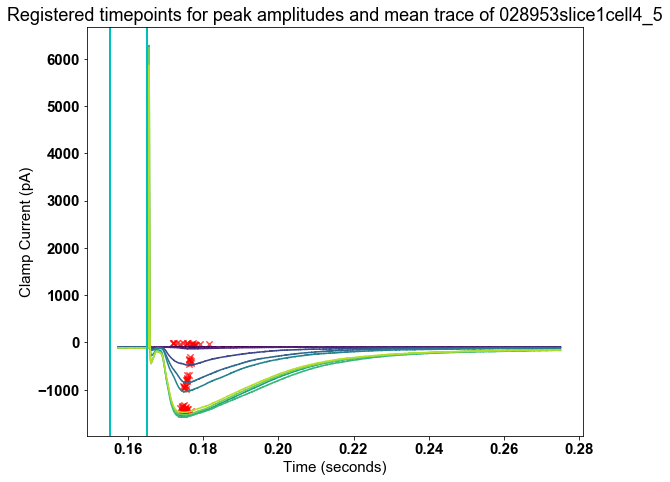

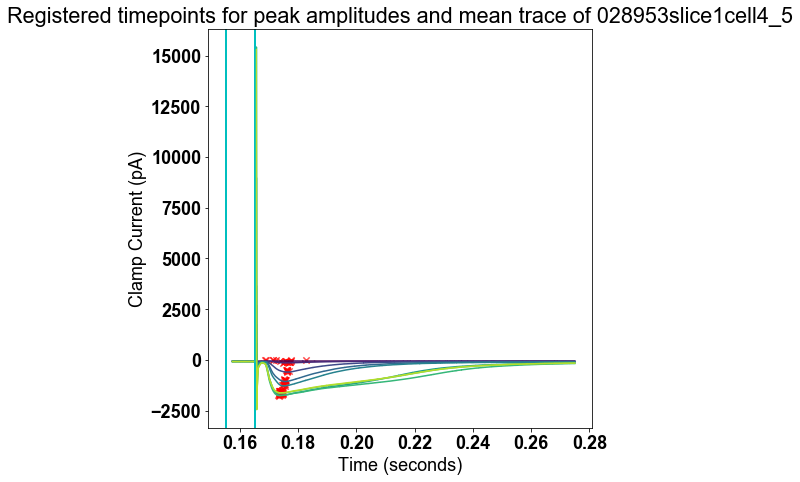

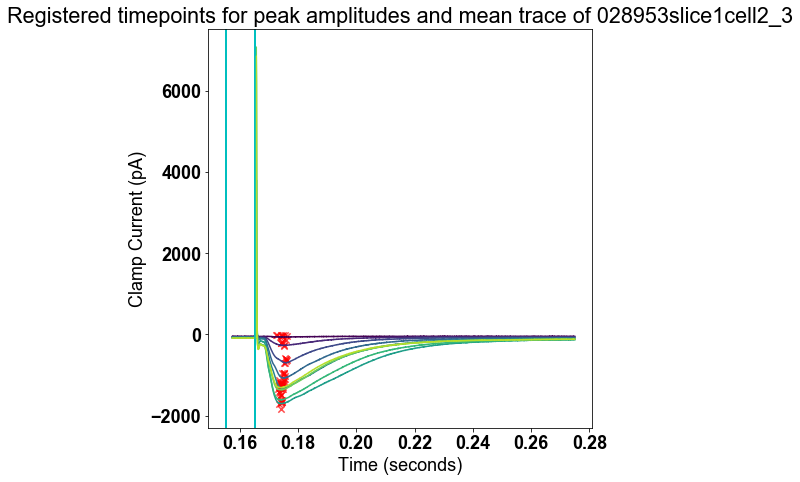

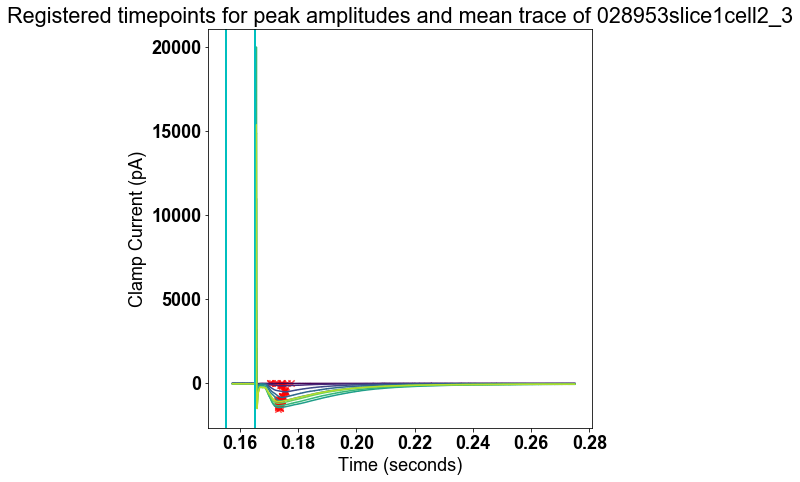

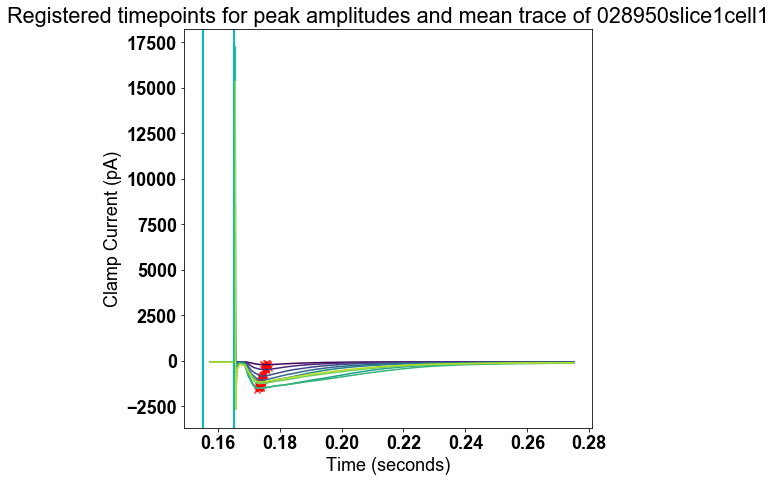

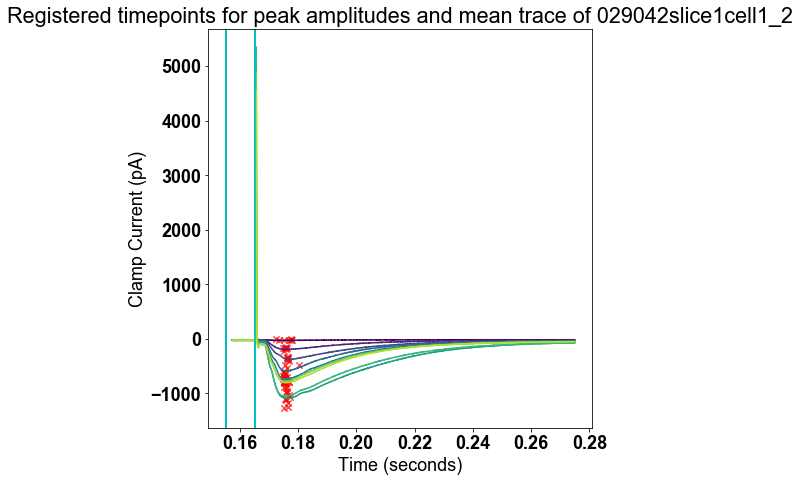

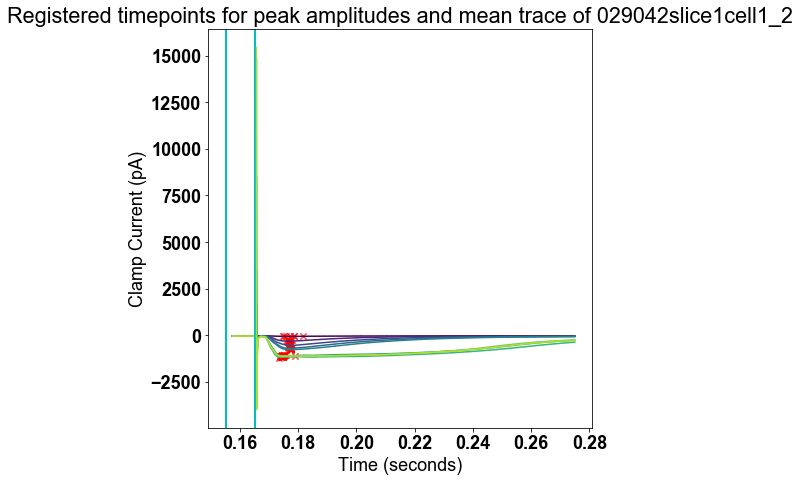

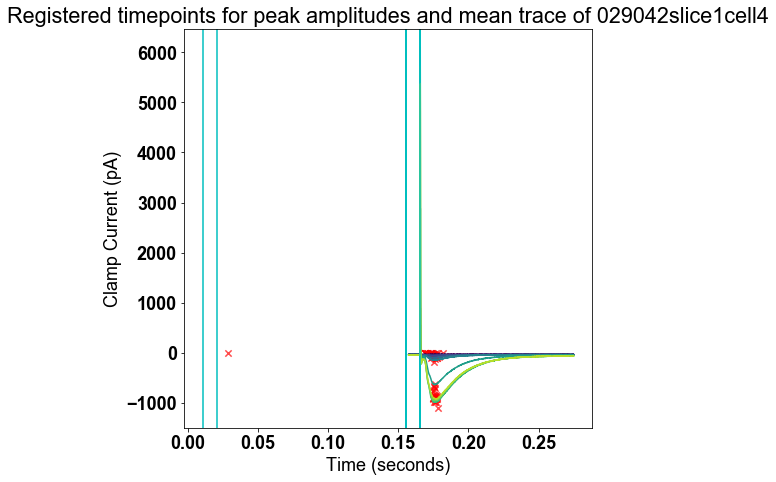

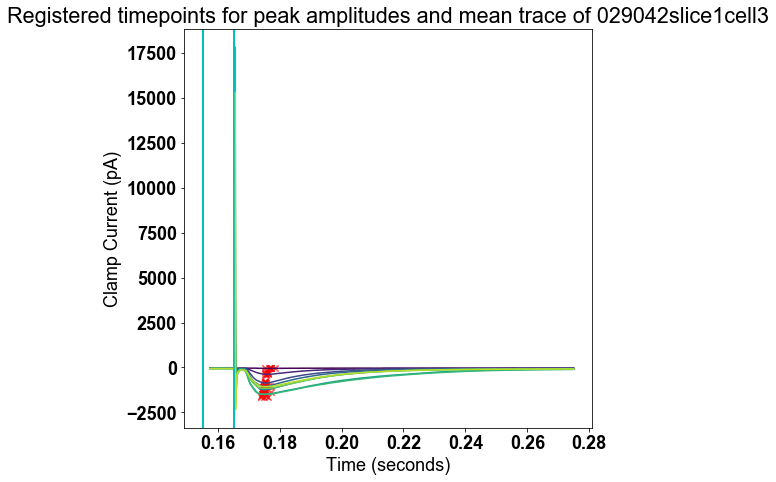

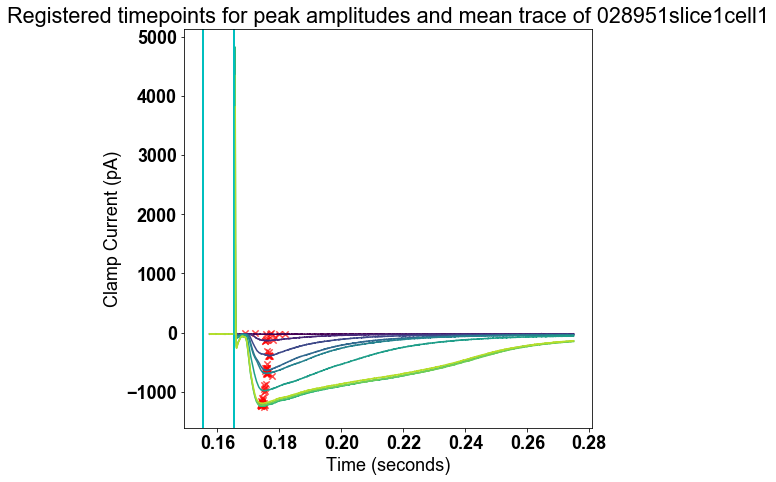

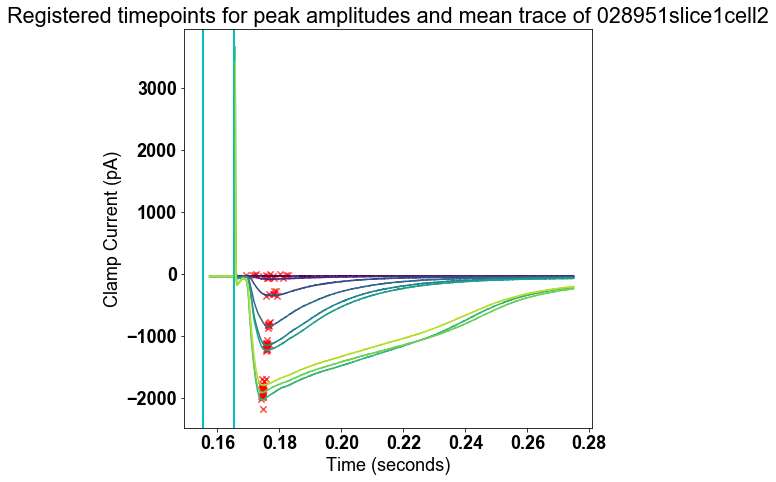

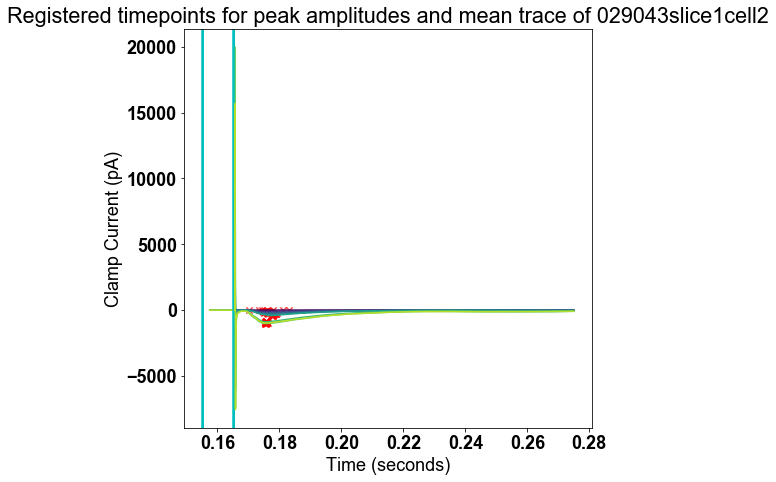

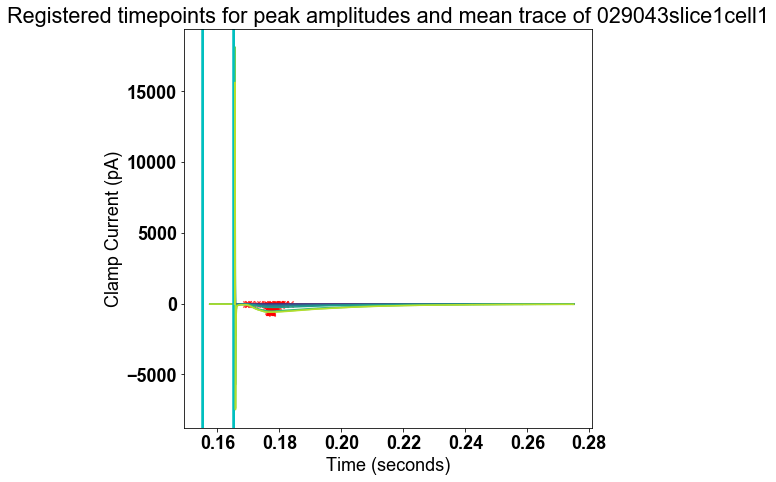

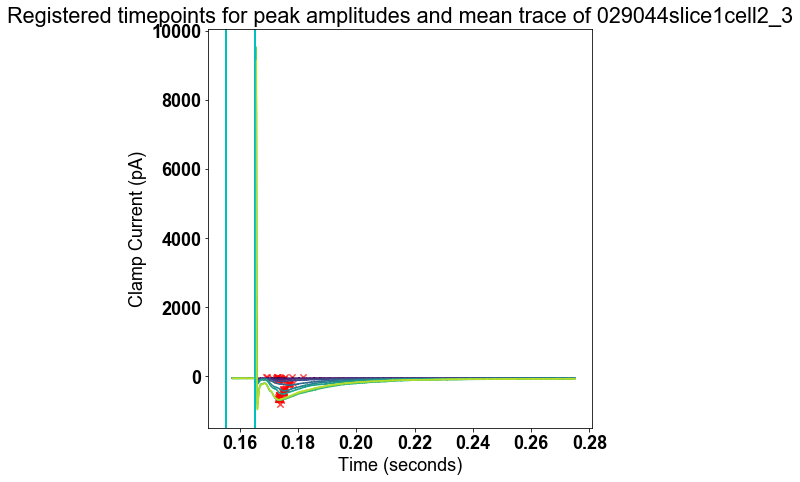

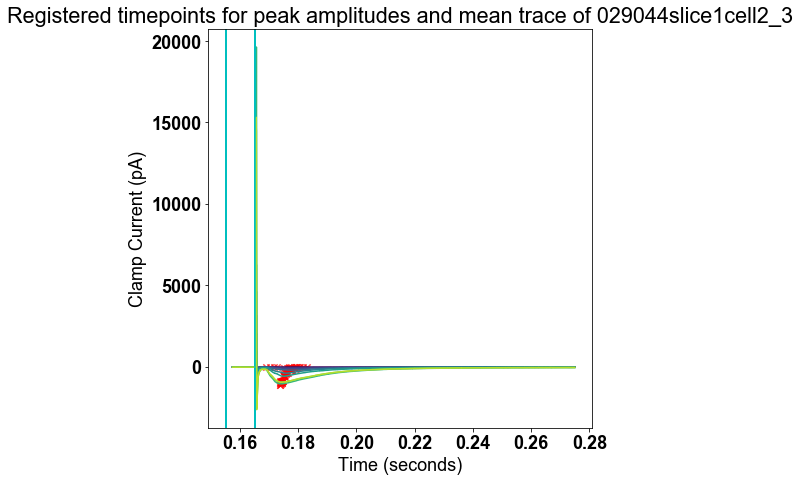

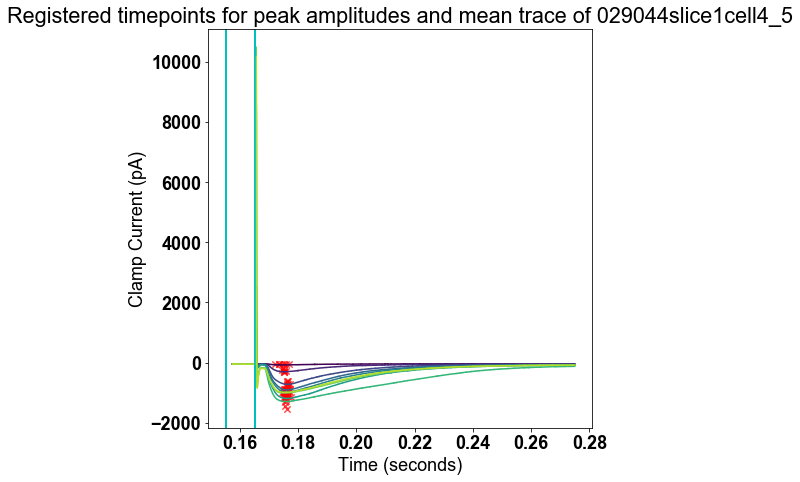

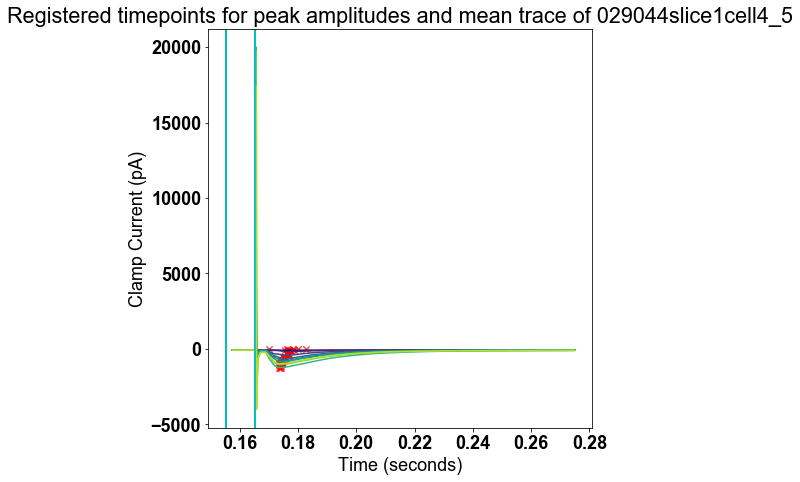

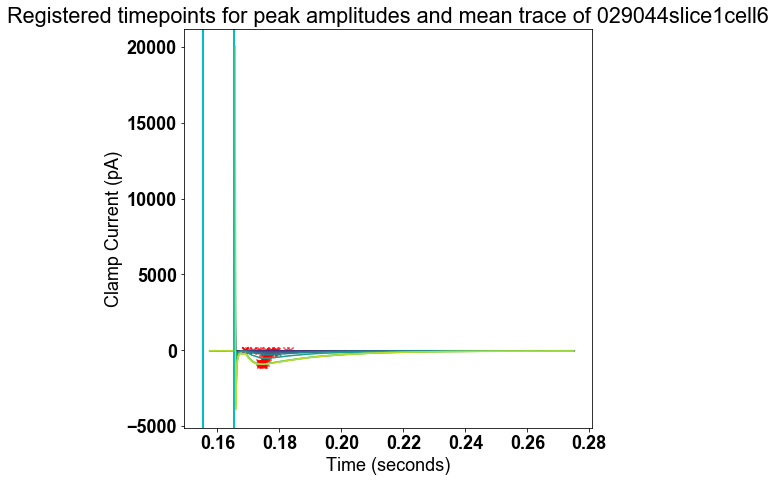

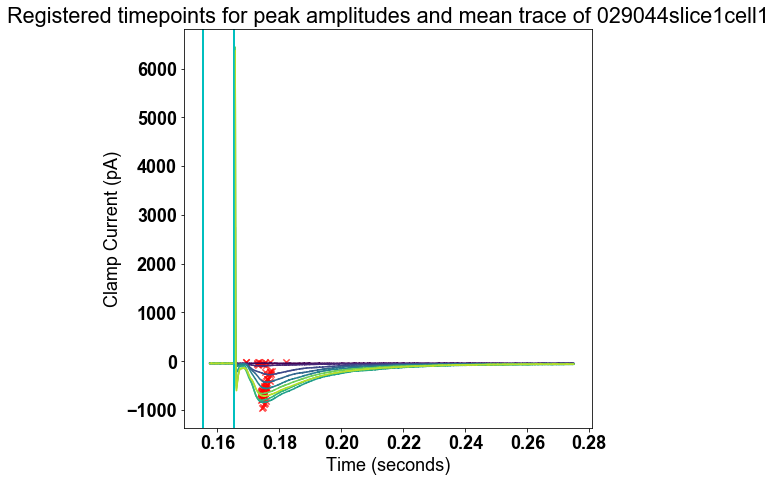

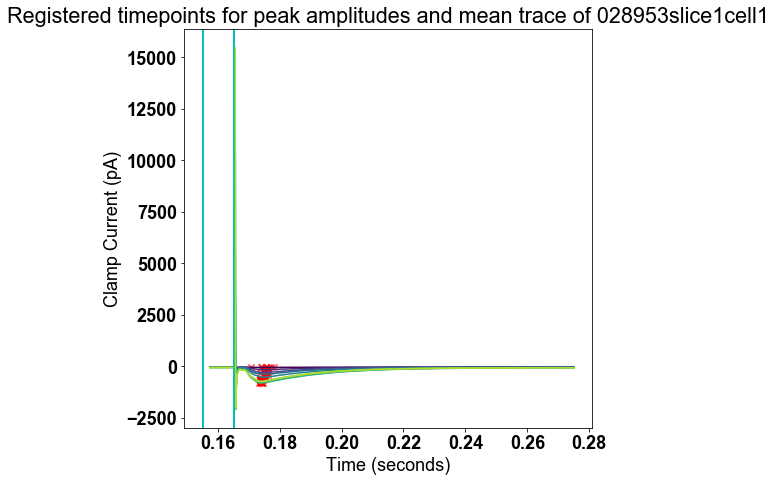

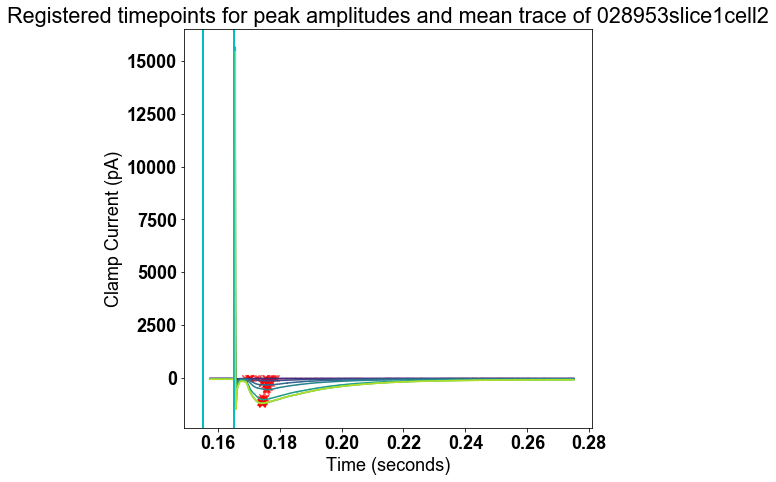

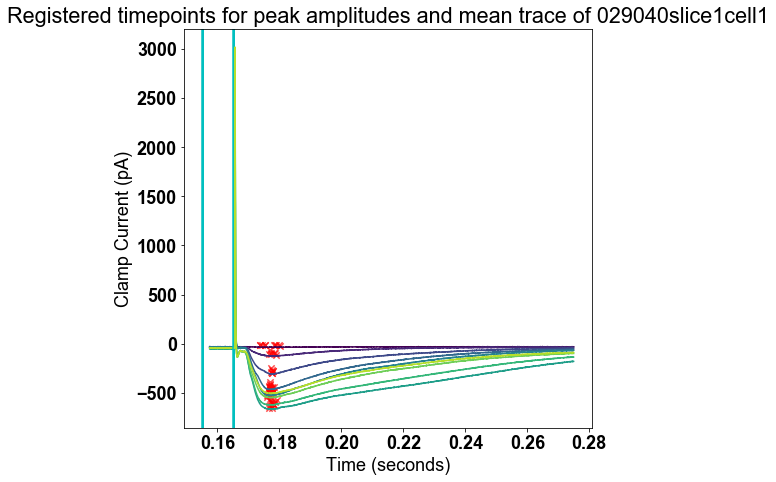

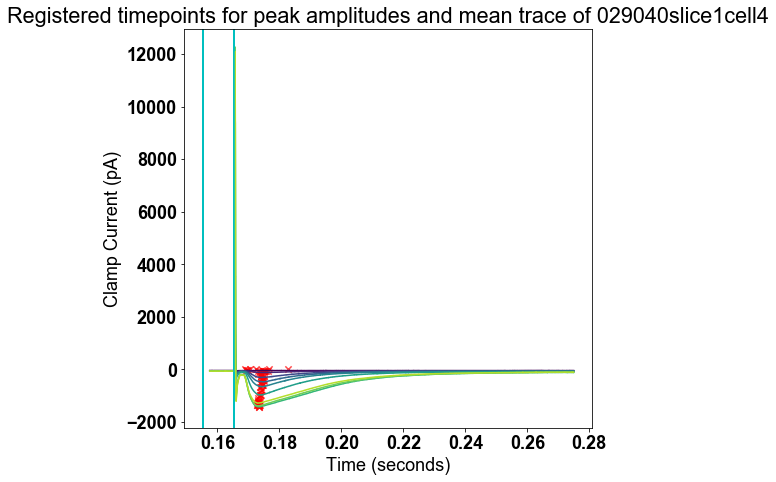

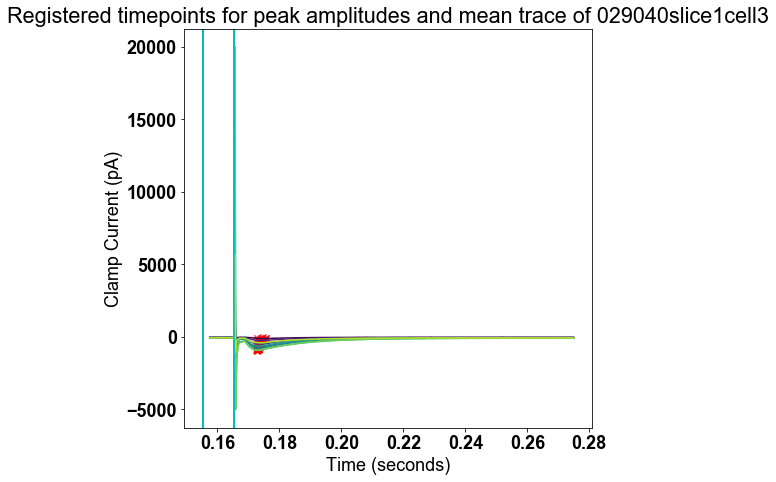

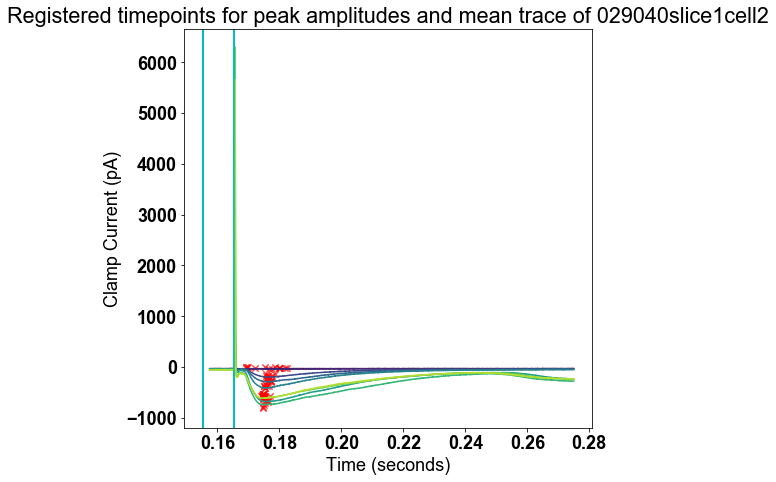

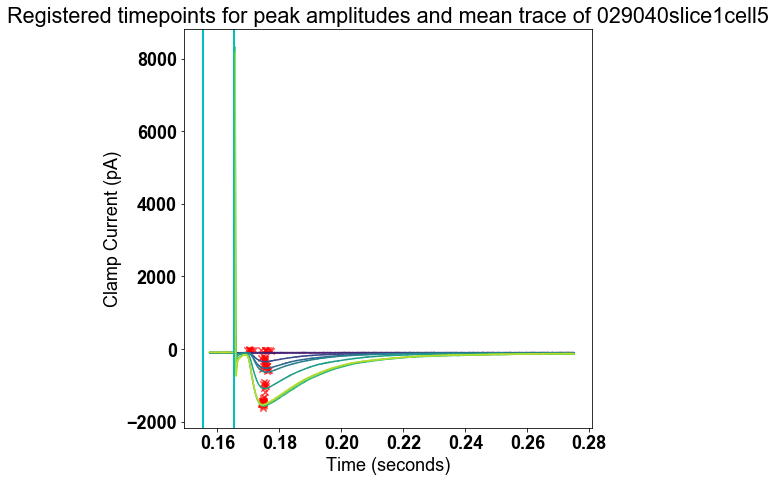

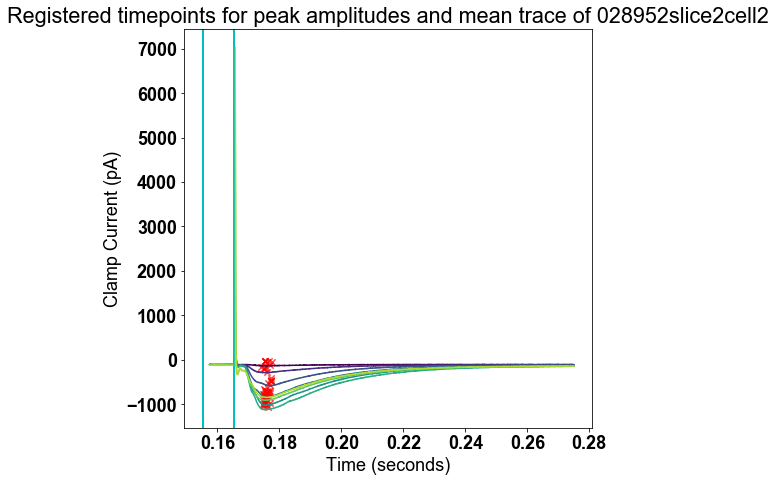

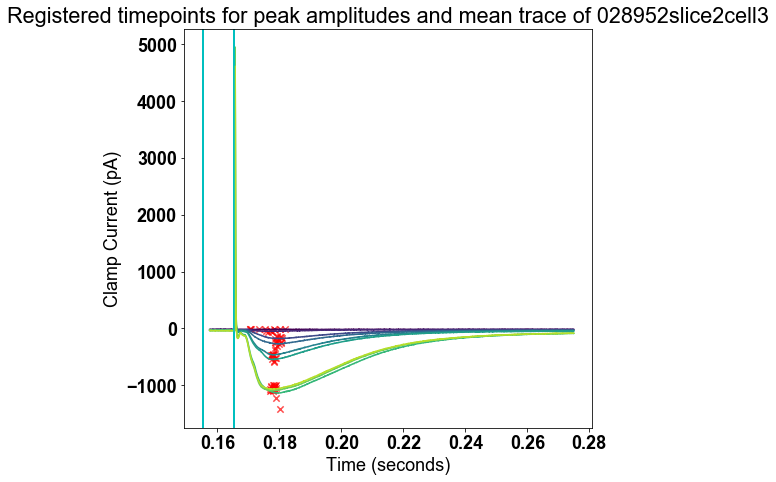

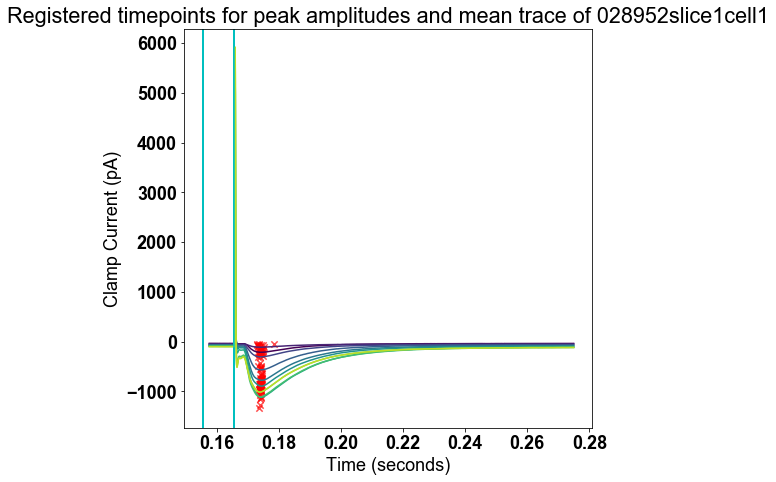

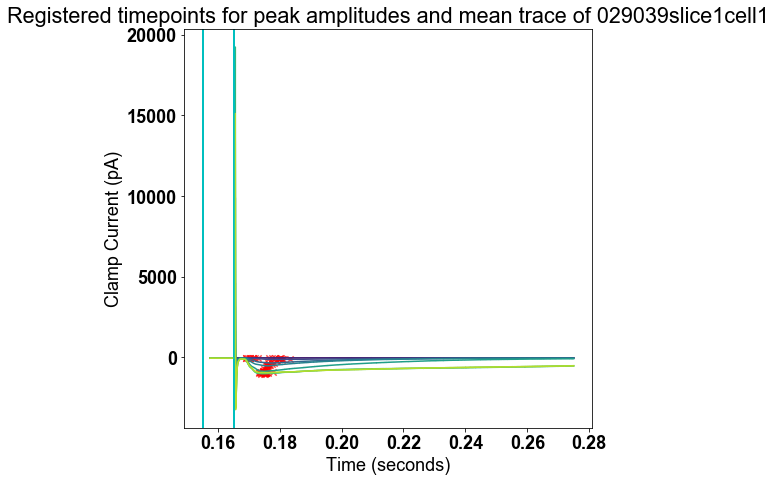

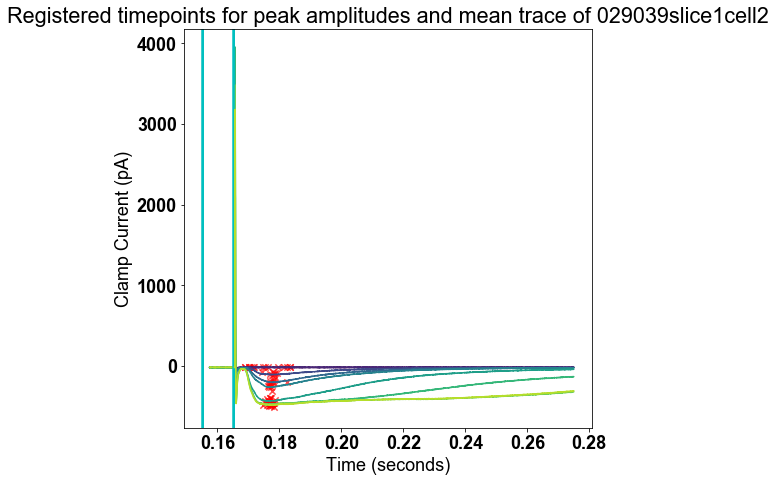

In [23]:
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/adrianalejandro/Desktop/Ephys_pipeline/input_output_rescue_test') #switch to direcotry with data folder

#Choose excel file with genotypes
global_df = pnd.DataFrame()
gentp_filename = filedialog.askopenfilename()
genotypes = pnd.read_excel(gentp_filename)
datapoint = 0 # This will increase by 1 with every iteration of making a dataframe for a cell

#Choose directory with all mouse data
path = askdirectory() # dialog box to choose path
os.chdir(path) #change directory to that path
gen_dir = os.getcwd() #string with name of that path
mouse_folders = os.listdir('.') #list folders corresponding to each mouse
for mouse in mouse_folders:
    if mouse == '.DS_Store': #my computer still thinks I'm using an extenral backup drive, please ignore this
        os.remove('.DS_Store') #(so annoying)

# FOR 1: Go to each folder in dataset that corresponds to one mouse
for mousename in mouse_folders:
    genotype = genotypes.loc[genotypes['mouse'] == mousename, 'genotype_short'].item() # get genotype label of mouse
    mouse_dir = gen_dir + '/' + mousename # get directory for one mouse
    os.chdir(mouse_dir)  #change directory to that mouse
    if os.path.exists('.DS_Store') == True: # external drive again
        os.remove('.DS_Store') #(ugh)    
    mouse_wd = os.getcwd() 
    cell_folders = os.listdir(mouse_wd) # list the cells (directories) of that mouse

# FOR 2: Go to each subfolder that corresponds to each cell of one mouse    
    for cell in cell_folders:
        if cell == '.DS_Store': #external drive again
            os.remove('.DS_Store') #(ughhh)    
        elif 'cell' in cell and 'processed' not in cell and 'IClamp' not in cell:
            processed_file = cell + '_processed' #string with name of cell and added suffix
            processed_dir = mouse_wd + '/' + processed_file #turn that into a directory name
            if not os.path.exists(processed_dir):
                os.mkdir(processed_dir) #if it doesn't exist yet, create new folder called cellname_processed
            cell_dir = mouse_dir + '/' + cell
            os.chdir(cell_dir)# change directory to one cell of one mouse
            cell_wd = os.getcwd()
            if os.path.exists('.DS_Store') == True: # external drive again
                os.remove('.DS_Store') #(uuuughhhh)       
                
# KEY STEP - get values from experiment excel files (from lab notes)            
            contents = os.listdir('.')
            stim_int, cellnum, valid_ABFs = get_xlxs_data(mousename,contents)
            cell_channels = [*range(cellnum)]  #to find out how many cells were recorded at a time
            
# FOR 3: Generate dataframes and save onto _processed folder in mouse directory, one per each cell 
            for ch in cell_channels:
                datapoint = datapoint + 1 # will later be used to know how many datapoints in input-output curve
                ch_ind = ch*2 # in ABF files, channels 0 and 1 are for left electrode, 2 and 3 are right electrode
                cell_ID = ch + 1
                summary,all_peak_times,cell_fig = data_summary_percell_v3(cell,ch_ind,valid_ABFs,
                                                                          stim_int,genotype,datapoint)
                global_df = global_df.append(summary, ignore_index=True)
                summ_path = processed_dir + '/' + cell + '_' + str(cell_ID) + '_summary.csv'      
                plot_path = processed_dir + '/'  + cell + '_' + str(cell_ID) + '_plot'      
                summary.to_csv(summ_path, index = True)
                plt.savefig(plot_path)

### II. Plotting an input-output curve and saving summary tables for later analysis in Prism (I know, I wanted statistics in this thing too)

In [24]:
dataset = global_df[['cell','genotype','stimulus_intensity_uA','Peak_amplitude_pA']] #filter out Membrane test data
dataset = dataset.dropna() #remove any rows with nan values
#dataset = dataset[dataset['stimulus_intensity_uA']<=0.25] #uncomment to zoom in on intensities <25 microAmps
KO_table = dataset[dataset['genotype']=='KO']
WT_table = dataset[dataset['genotype']=='WT']
res_table = dataset[dataset['genotype']== 'rescue']
KO_summary = KO_table.groupby("stimulus_intensity_uA",).describe(percentiles=None)
WT_summary = WT_table.groupby("stimulus_intensity_uA",).describe(percentiles=None)
rescue_summary = res_table.groupby("stimulus_intensity_uA",).describe(percentiles=None)

#pipeline_path = '/Users/adrianalejandro/Desktop/Ephys_pipeline/'
#KO_summary.to_csv(pipeline_path+'KO_summary.csv', index = True)
#WT_summary.to_csv(pipeline_path+'WT_summary.csv', index = True)
#rescue_summary.to_csv(pipeline_path+'rescue_summary.csv', index = True)
#path = '/Users/adrianalejandro/Desktop/' #Choose where to save tables of data separated by genotype
#KO_table.to_csv(path+'KO_IO_data.csv', index = True)
#WT_table.to_csv(path+'WT_IO_data.csv', index = True)
#res_table.to_csv(path+'rescue_IO_data.csv', index = True)

In [25]:
for gen in dataset.genotype.unique(): #quick check that all genotypes have the same stim intensities
    print(gen)
    one_gen = dataset['genotype'] == gen
    one_gen_df = dataset[one_gen]
    for intensity in one_gen_df.stimulus_intensity_uA.unique():
        print(intensity)

KO
0.01
0.025
0.05
0.075
0.1
0.25
0.5
0.75
1.0
WT
0.01
0.025
0.05
0.075
0.1
0.25
0.5
0.75
1.0
rescue
0.01
0.025
0.05
0.075
0.1
0.25
0.5
0.75
1.0


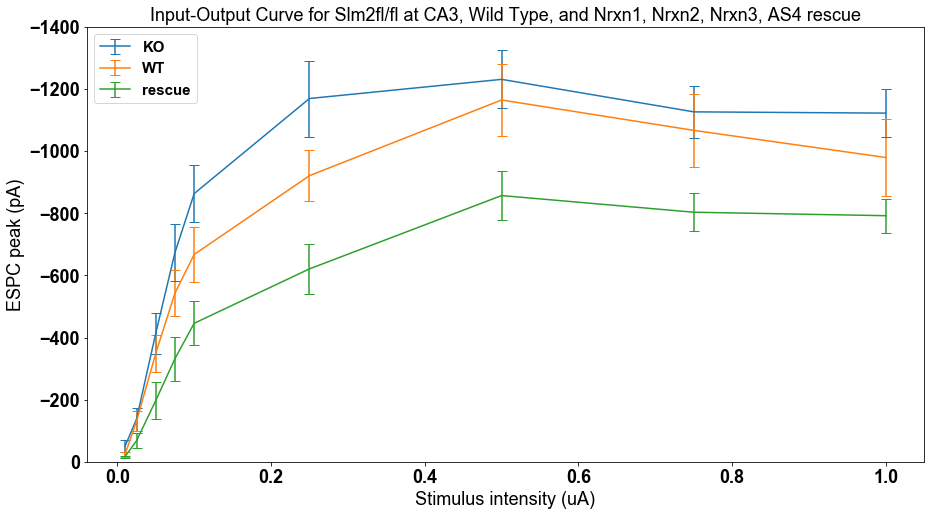

In [26]:
fig = plt.figure(figsize=(15, 8))
stimuli = dataset.stimulus_intensity_uA.unique()
for gen in dataset.genotype.unique():
    pA_means = []
    pA_sems = []
    one_gen = dataset['genotype'] == gen
    one_gen_df = dataset[one_gen]
    for stim_int in one_gen_df.stimulus_intensity_uA.unique():
        one_int = one_gen_df['stimulus_intensity_uA']==stim_int
        one_int_df = one_gen_df[one_int]
        one_int_peaks = one_int_df['Peak_amplitude_pA'].values
        int_pA_mean = np.mean(one_int_peaks)
        int_pA_sem = np.std(one_int_peaks)/np.sqrt(len(one_int_peaks))
        pA_means.append(int_pA_mean)
        pA_sems.append(int_pA_sem)
    pA_means = pA_means[0:len(stimuli)] # cut any extra numbers at the end that could be nans or whatever
    pA_sems = pA_sems[0:len(stimuli)]
    plt.errorbar(stimuli, pA_means, pA_sems,label=gen,capsize=5)

plt.rcParams.update({'font.size': 15})
plt.ylim(0,-1400) 
plt.title('Input-Output Curve for Slm2fl/fl at CA3, Wild Type, and Nrxn1, Nrxn2, Nrxn3, AS4 rescue')
plt.ylabel('ESPC peak (pA)')
plt.xlabel('Stimulus intensity (uA)')
plt.legend()
#fig.savefig('filename.eps', format='eps') #in case you want to save it somewhere, idk